# (Experimental) Interactive Viewer in a Jupyter Notebook

You can view any Wisp checkpoint in a jupyter notebook. Here we show a minimal proof-of-concept example with **interactive** camera control.
Note that this feature is experimental and does not achieve the fastest viewing performance.

To get started, **make sure to `pip install ipycanvas` and then restart the entire jupyter process** (lab or notebook), not just the Kernel.

In [1]:
import logging
import os
import PIL.Image
import time
import torch

from ipycanvas import MultiCanvas, Canvas, hold_canvas
from ipywidgets import VBox, Layout, Button, ToggleButton, HBox, Label, Checkbox, Output, Image
from kaolin.utils.testing import tensor_info

import wisp
import wisp.renderer.web.jupyter_utils
from wisp.app_utils import default_log_setup
from wisp.framework import WispState
from wisp.renderer.core import RendererCore
from wisp.renderer.core.api import add_pipeline_to_scene_graph
from wisp.renderer.web.jupyter_utils import WISP_ROOT_DIR

%load_ext autoreload
%autoreload 2

default_log_setup(logging.INFO)

def log_tensor(*args, **kwargs):
    logging.info(tensor_info(*args, **kwargs))

## Load a Pre-trained Pipeline from File

The jupyter viewer works with all Wisp pipeline checkpoints, both NERF and SDF. 
For example, to get a sample NERF checkpoint run: 

`python app/nerf/main_nerf.py --dataset-path data/lego --config app/nerf/configs/nerf_hash.yaml --save-every 10`.

Results will be saved under `_results`.

In [2]:
REL_PATH = '_results/logs/runs/test-nerf/20230210-113127/model.pth'  # Change to your model path
CHECKPOINT = os.path.join(WISP_ROOT_DIR, REL_PATH)
assert os.path.isfile(CHECKPOINT), f'Please set the path to a checkpoint on your machine: {CHECKPOINT}'

pipeline = torch.load(CHECKPOINT).cuda()
print(f'Loaded pipeline with default number of steps: {pipeline.tracer.num_steps}')

Loaded pipeline with default number of steps: 1024


## Set up Rendering and Check Output

Let's first make sure we can render this checkpoint.

/home/mshugrina/anaconda3/envs/wisp/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


2023-03-10 07:33:13,693|    INFO| rgb orig: torch.Size([800, 800, 4]) (torch.float32)  - [min 0.0000, max 255.0001, mean 21.9504] 
2023-03-10 07:33:13,698|    INFO| rgb processed: (800, 800, 4) (uint8)  - [min 0.0000, max 255.0000, mean 21.8811] 


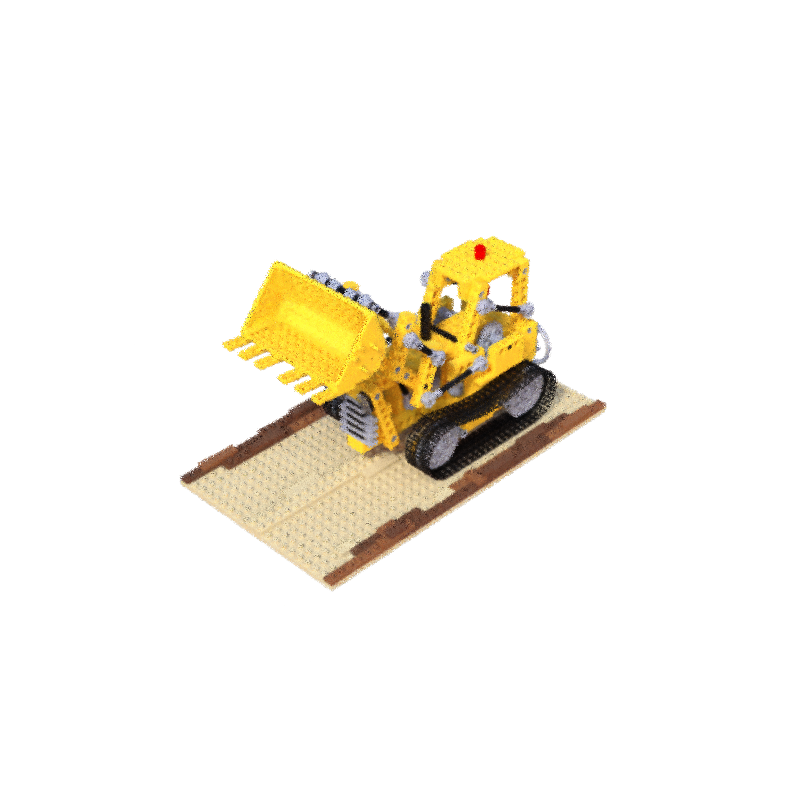

In [3]:
# Initialize
wisp_state = WispState()
wisp_state.renderer.target_fps = 10
add_pipeline_to_scene_graph(wisp_state, 'my neural field', pipeline, batch_size=2**14)
render_core = RendererCore(wisp_state)
render_core.redraw()

# Let's try rendering
rgb = render_core.render(force_render=True).image().rgba.detach()
log_tensor(rgb, 'rgb orig', print_stats=True)
rgb = rgb.clip(0, 255).cpu().byte().numpy()
log_tensor(rgb, 'rgb processed', print_stats=True)
PIL.Image.fromarray(rgb)           

## Set Up Live Viewer

Now, let's view this interactively! Click and drag left mouse button over the render below to interactively change view.

**Important**: if nothing is showing up after running the cell below, you may need to restart your jupyter process (not just the kernel) and/or debug your ipywidget/ipycanvas installation.

In [8]:
cwidth = render_core.camera.width
cheight = render_core.camera.height

# 1. Create HTML5 Canvas widget for displaying the render and handling mouse events
out = Output()
canvas = Canvas(width=cwidth, height=cheight, layout=Layout(width="800px"), sync_image_data=True)  

# 2. Initialize turntable controller that is hooked up to the canvas events
turntable = wisp.renderer.web.jupyter_utils.LiveCameraControl.create_easy_turntable(wisp_state, render_core, canvas)
turntable.activate(out, enable_output_on_move=True)  # False is faster, but silent errors may occurr 
time.sleep(1)  # handles concurrency issues with sanity checks below

# 3. (optional) Sanity check that internal controller render function is working
with hold_canvas():
    test_rendering = turntable.test_rendering(False)  # lowres
    log_tensor(test_rendering, 'test_rendering')
    
    test_rendering = turntable.test_rendering(True)  # highres
    log_tensor(test_rendering, 'test_rendering')
    
    image = Image(value=wisp.renderer.web.jupyter_utils.np_img_to_compressed_bytes(test_rendering, 'png'))
    canvas.draw_image(image, 0, 0, cwidth, cheight)

# 4. (optional) Hook up events for optional buttons
# Note: unfortunately it's hard to hook up middle button for zoom to ipycanvas.
@out.capture()
def on_zoom_in(b):
    turntable.zoom(-1.5)
    
@out.capture()
def on_zoom_out(b):
    turntable.zoom(1.5)
    
@out.capture()
def save_frame(b):
    wisp.renderer.web.jupyter_utils.save_canvas_render(canvas, 'render.png')
    
@out.capture()
def toggle_output(change):
    global out
    out.layout.display = "inline" if change.new else "none"

zoom_in = Button(description='Zoom In')
zoom_out = Button(description='Zoom Out')
save_btn = Button(description='Save Frame')
zoom_in.on_click(on_zoom_in)
zoom_out.on_click(on_zoom_out)
save_btn.on_click(save_frame)
toggle_output_btn = ToggleButton(description="Toggle Output", icon="check", value=True)
toggle_output_btn.observe(toggle_output, names="value")

# 5. Display everything
VBox((HBox((canvas, VBox((zoom_in, zoom_out, save_btn, toggle_output_btn)))), out))

2023-03-10 07:34:38,727|    INFO| test_rendering: (200, 200, 4) (uint8)  
2023-03-10 07:34:39,029|    INFO| test_rendering: (800, 800, 4) (uint8)  
